Construct a PCovR Map
===================

In [1]:
from sklearn.datasets import load_diabetes

from matplotlib import pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm

import numpy as np

from skcosmo.decomposition import PCovR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge

cmapX = cm.plasma
cmapy = cm.Greys

For this, we will use the [diabetes dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html) from sklearn.

In [2]:
X, y = load_diabetes(return_X_y=True)
y = y.reshape(X.shape[0], -1)

X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y)

Computing a simple PCovR and making a fancy plot of the results

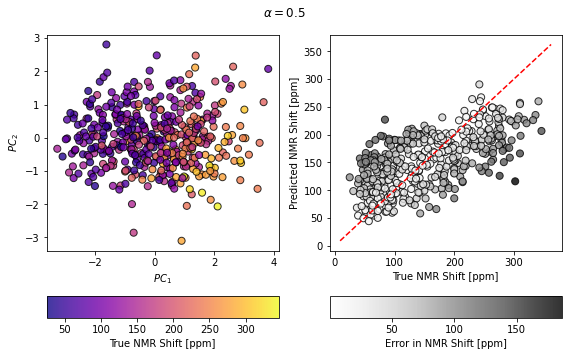

In [3]:
mixing = 0.5
pcovr = PCovR(mixing=mixing, 
              regressor=Ridge(alpha=1E-8, fit_intercept=False, tol=1E-12),
              n_components=2, )
pcovr.fit(X_scaled, y_scaled)
T = pcovr.transform(X_scaled)
yp = y_scaler.inverse_transform(pcovr.predict(X_scaled))

fig, ((axT, axy), (caxT, caxy)) = plt.subplots(
    2, 2, figsize=(8, 5), gridspec_kw=dict(height_ratios=(1, 0.1))
)

scatT = axT.scatter(T[:, 0], T[:, 1], s=50, alpha=0.8, c=y, cmap=cmapX, edgecolor="k")
axT.set_xlabel(r"$PC_1$")
axT.set_ylabel(r"$PC_2$")
fig.colorbar(scatT, cax=caxT, label="True NMR Shift [ppm]", orientation="horizontal")

scaty = axy.scatter(y, yp, s=50, alpha=0.8, c=np.abs(y - yp), cmap=cmapy, edgecolor="k")
axy.plot(axy.get_xlim(), axy.get_xlim(), 'r--')
fig.suptitle(r"$\alpha=$" + str(mixing))

axy.set_xlabel(r"True NMR Shift [ppm]")
axy.set_ylabel(r"Predicted NMR Shift [ppm]")
fig.colorbar(scaty, cax=caxy, label="Error in NMR Shift [ppm]", orientation="horizontal")

fig.tight_layout()

Surveying Many Mixing Parameters

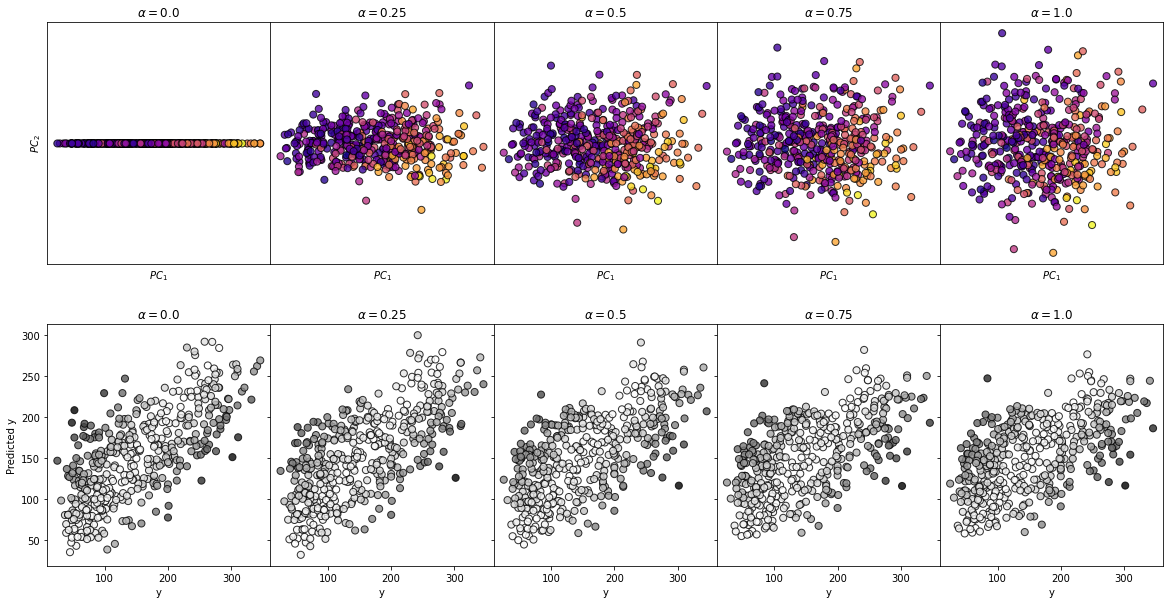

In [4]:
n_alpha = 5

fig, axes = plt.subplots(2, n_alpha, 
                         figsize=(4*n_alpha, 10),
                         sharey='row'
                        )

for i, mixing in enumerate(np.linspace(0, 1, n_alpha)):
    

    pcovr = PCovR(mixing=mixing, 
                      regressor=Ridge(alpha=1E-8, fit_intercept=False, tol=1E-12),
                      n_components=2, )
    pcovr.fit(X_scaled, y_scaled)
    T = pcovr.transform(X_scaled)
    yp = y_scaler.inverse_transform(pcovr.predict(X_scaled))

    axes[0, i].scatter(T[:, 0], 
                       T[:, 1], 
                       s=50, 
                       alpha=0.8,
                       c=y, 
                       cmap=cmapX,  
                       edgecolor='k'
                      )
    axes[0,i].set_title(r"$\alpha=$" + str(mixing))
    axes[0,i].set_xlabel(r"$PC_1$")
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])

    axes[1, i].scatter(y, 
                       yp, 
                       s=50, 
                       alpha=0.8,
                       c=np.abs(y-yp), 
                       cmap=cmapy, 
                       edgecolor='k')
    axes[1,i].set_title(r"$\alpha=$" + str(mixing))
    axes[1,i].set_xlabel("y")
    
axes[0,0].set_ylabel(r"$PC_2$")
axes[1,0].set_ylabel("Predicted y")

fig.subplots_adjust(wspace=0, hspace=0.25)
plt.show()

Construct a Kernel PCovR Map
=========================

Moving from PCovR to KernelPCovR is much like moving from PCA to KernelPCA in `sklearn`. Like KernelPCA, KernelPCovR can compute any pairwise kernel supported by `sklearn` or operate on a precomputed kernel.

In [5]:
from skcosmo.decomposition import KernelPCovR

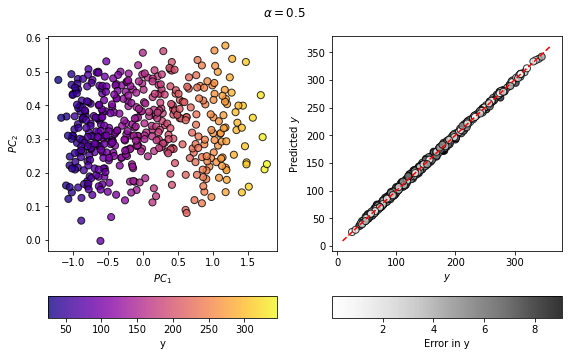

In [6]:
mixing = 0.5
kpcovr = KernelPCovR(
    mixing=mixing,
    regressor=KernelRidge(
        alpha=1e-8,
        kernel="rbf",
        gamma=0.1,
    ),
    kernel="rbf",
    gamma=0.1,
    n_components=2,
)
kpcovr.fit(X_scaled, y_scaled)
T = kpcovr.transform(X_scaled)
yp = y_scaler.inverse_transform(kpcovr.predict(X_scaled))

fig, ((axT, axy), (caxT, caxy)) = plt.subplots(
    2, 2, figsize=(8, 5), gridspec_kw=dict(height_ratios=(1, 0.1))
)

scatT = axT.scatter(T[:, 0], T[:, 1], s=50, alpha=0.8, c=y, cmap=cmapX, edgecolor="k")
axT.set_xlabel(r"$PC_1$")
axT.set_ylabel(r"$PC_2$")
fig.colorbar(scatT, cax=caxT, label="y", orientation="horizontal")

scaty = axy.scatter(y, yp, s=50, alpha=0.8, c=np.abs(y - yp), cmap=cmapy, edgecolor="k")
axy.plot(axy.get_xlim(), axy.get_xlim(), "r--")
fig.suptitle(r"$\alpha=$" + str(mixing))

axy.set_xlabel(r"$y$")
axy.set_ylabel(r"Predicted $y$")
fig.colorbar(scaty, cax=caxy, label="Error in y", orientation="horizontal")

fig.tight_layout()

As you can see, the regression error has decreased considerably from the linear case, meaning that the map on the left can, and will, better correlate with the target values.

Note on KernelPCovR for Atoms, Molecules, and Structures
-----------------------------------------------------------------

Applying this to datasets involving collections of atoms and their atomic descriptors, it's important to consider the nature of the property you are learning and the samples you are comparing before constructing a kernel, for example, whether the analysis is to be based on whole structures or individual atomic environments. For more detail, see Appendix C of [Helfrecht 2020](https://iopscience.iop.org/article/10.1088/2632-2153/aba9ef) or regarding kernels involving gradients [Musil 2021](https://arxiv.org/pdf/2101.08814.pdf).